In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import sys
sys.path.append('..')
import functools
import math

import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq_torch

In [25]:
mixmeans_test = torch.tensor([[  1.8033],
                           [ -1.4296],
                           [ -1.9691],
                           [  1.2147],
                           [ -6.9166],
                           [-11.5672],
                           [ -1.5860],
                           [ -4.3302],
                           [  8.7410],
                           [ -1.3793],
                           [ -4.8774],
                           [  2.3949]])
mixvars_test = torch.ones((12,1))
mixweights_test = torch.ones(12)/12

In [40]:
def logprob_mixgaussians(x):
    return bvbq_torch.distributions.MixtureDiagonalNormalDistribution.logprob_(
                        x,mixmeans_test,mixvars_test,mixweights_test).reshape(-1,1)
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

xdata = torch.linspace(-20,20,11).reshape(-1,1)
ydata = logprob_mixgaussians(xdata)
logprobgp = bvbq_torch.gp.SimpleGP(1,kind='smatern52',noise=0,zeromax=True)
logprobgp.mean = -30.0
logprobgp.fix_mean()
logprobgp.fix_noise()
logprobgp.set_data(xdata,ydata,empirical_params=False)
logprobgp.optimize_params(tol=1e-1)

{'raw_theta': tensor(7.9376), 'raw_lengthscale': tensor(4.7333)}

In [41]:
logprobgp.mean

tensor(-30.)

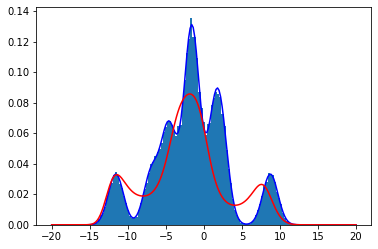

In [42]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
# yplot1 = logprob_t(xplot,2.5)
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
samples1 = bvbq_torch.distributions.MixtureDiagonalNormalDistribution.sample_(100000,
                                                             mixmeans_test,
                                                             mixvars_test,
                                                             mixweights_test).detach().numpy()
plt.hist(samples1.flatten(),density=True,bins=100);

In [43]:
nmixtures = 3
ndim = 1
mixmeans = torch.randn(nmixtures,1)
mixvars = torch.distributions.HalfNormal(1.0).sample((nmixtures,1))
mixweights = torch.distributions.Dirichlet(torch.ones(nmixtures)).sample()
mean = torch.randn((1,))
var = torch.distributions.HalfNormal(1.0).sample((1,))

In [44]:
alpha_relbo = 1e-1
maxiter_relbo = 300
alpha_boost = 1e-1
maxiter_boost = 100
maxiter = 50

mixmeans = torch.zeros(1,ndim)
mixvars = (20.0/3)**2*torch.ones(1,ndim)
mixweights = torch.ones(1)
for k in range(maxiter):
    mean,var = bvbq_torch.bvbq.propose_component_mvn_mixmvn_relbo(
                logprobgp,mixmeans,mixvars,mixweights)
    mixmeans,mixvars,mixweights = bvbq_torch.bvbq.update_distribution_mvn_mixmvn(
                                            logprobgp,
                                            mean,var,
                                            mixmeans,mixvars,
                                            mixweights,
                                            lr=1e-1/(k+1),
                                            weight_delta=1e-6,
                                            decaying_lr=False)

    print(mixmeans[-1],mixvars[-1],mixweights[-1])
mixmeans,mixvars,mixweights = bvbq_torch.utils.cut_components_mixmvn(mixmeans,mixvars,mixweights)
distrib = bvbq_torch.distributions.MixtureDiagonalNormalDistribution(mixmeans,mixvars,mixweights)

tensor([-2.5991]) tensor([4.2634]) tensor(0.8330)
tensor([-11.7290]) tensor([0.8644]) tensor(0.1415)
tensor([7.3850]) tensor([2.0001]) tensor(0.1247)
tensor([2.4804]) tensor([4.5907]) tensor(0.0874)
tensor([-0.6104]) tensor([4.3233]) tensor(0.1025)
tensor([-8.2643]) tensor([8.6179]) tensor(0.1298)
tensor([-0.8887]) tensor([3.4612]) tensor(0.0803)
tensor([-2.4336]) tensor([5.6553]) tensor(0.0318)
tensor([10.9285]) tensor([0.5126]) tensor(1.0000e-06)
tensor([-2.9162]) tensor([7.4556]) tensor(0.0170)
tensor([6.9618]) tensor([4.2148]) tensor(0.0343)
tensor([-2.5095]) tensor([6.1284]) tensor(0.0221)
tensor([-9.0747]) tensor([4.3135]) tensor(0.0499)
tensor([-1.4478]) tensor([7.4216]) tensor(0.0297)
tensor([-1.7548]) tensor([5.7507]) tensor(0.0271)
tensor([-1.1633]) tensor([7.6481]) tensor(0.0109)
tensor([-1.7637]) tensor([6.3284]) tensor(0.0128)
tensor([-1.9912]) tensor([6.1110]) tensor(0.0091)
tensor([6.3968]) tensor([5.4392]) tensor(0.0171)
tensor([-2.2005]) tensor([7.6528]) tensor(0.0103)

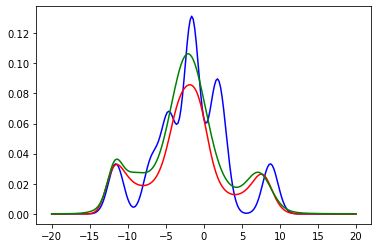

In [45]:
xplot = np.linspace(-20,20,201).reshape(-1,1)
yplot1 = logprob_mixgaussians(xplot).detach().numpy()
yplot2 = logprobgp.predict(xplot,return_cov=False).detach().numpy()
yplot3 = distrib.logprob(xplot).detach().numpy().reshape(-1,1)
plt.plot(xplot,np.exp(yplot1),'b')
plt.plot(xplot,np.exp(yplot2),'r')
plt.plot(xplot,np.exp(yplot3),'g')

In [18]:
logprobgp.predict(distrib.sample(1))

(tensor([-2.9506]), tensor([[0.0055]]))

In [23]:
x = distrib.sample(1)
x.requires_grad = True
res = bvbq_torch.acquisition_functions.prospective_prediction(x,logprobgp,distrib)
res.backward()

tensor([[9.0618e-05]])